## Demo for learning single channel PSF from SMLM data given the stage tilt

##### Setup environment

In [1]:
import sys
sys.path.append("..")
from psflearning.psflearninglib import psflearninglib
from psflearning import io
from psflearning.makeplots import *
import tensorflow as tf

try:
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print('Running on GPU')
except:
    print('Running on CPU')

Running on GPU


##### Create psflearning object and load the config file
$\small\color{skyblue}{\mathrm{basefile}}$: config file with all parameters  
$\small\color{skyblue}{\mathrm{sysfile}}$: config file with microscope specific parameters  
For advanced user, pass in base file only as below to interact with all parameters:   
```python
    L.param = io.param.combine('config_base')
```

In [2]:
L = psflearninglib()
L.param = io.param.combine(basefile='config_base',psftype='insitu',channeltype='1ch',sysfile='TIRF')

##### Edit user defined parameters

In [3]:

L.param.datapath = r'Y:\Projects\Super Critical Angle Localization Microscopy\Data\10-06-2023\Data4/'
L.param.filelist = [r'Y:\Projects\Super Critical Angle Localization Microscopy\Data\10-06-2023\Data4\Data4-2023-10-7-17-36-53.h5']
L.param.gain = 0.44
L.param.ccd_offset = 100
L.param.option.insitu.stage_pos = 0.6 # micron, stage position relative to infocus at the coverslip
L.param.option.model.symmetric_mag = True
L.param.option.model.const_pupilmag = True
L.param.option.insitu.repeat = 3
L.param.roi.peak_height = 0.4
L.param.option.model.bin=1
L.param.option.model.n_max = 6

**Step 3**. use the following settings to relearn the PSF model with index mismatch.   
set `stage_tilt` to the value estimated from `demo_insituPSF_1ch_estimate_tilt.ipynb`

*Note:* when relearn the PSF model, run the notebook from the beginning, or click `Restart` and run from the beginning.

In [18]:
L.param.savename = L.param.datapath+'psf_kmed'
L.param.loss_weight.Inorm = 0.01 # weight for the minimizing the stage position
L.param.option.insitu.stage_tilt = [1.05685207, -0.84441123] # tilt in [y,x], unit: nm/pixel 
L.param.option.imaging.RI.med = 1.335
L.param.option.insitu.var_stagepos = True

##### Start learning

In [ ]:
images = L.load_data()
L.getpsfclass()
dataobj = L.prep_data(images)
resfile = L.iterlearn_psf(dataobj,time=0)

##### Show results

In [20]:
f,p = io.h5.load(resfile) # load result file

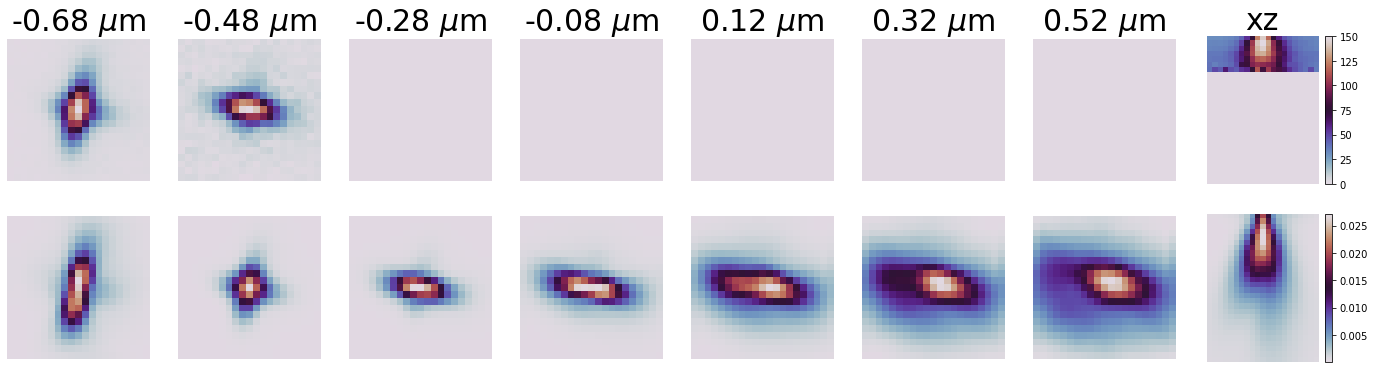

In [21]:
showpsfvsdata_insitu(f,p)

##### Optional plots

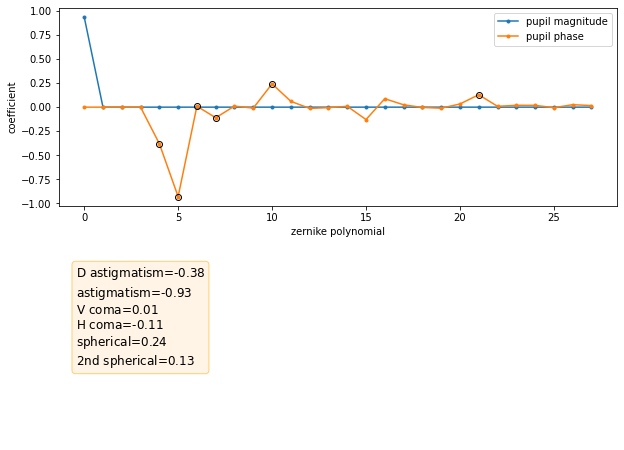

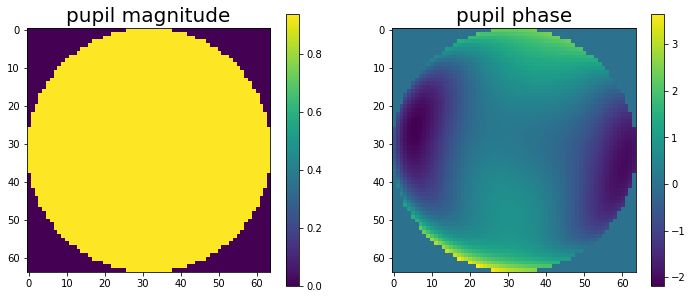

In [23]:
try:
    showzernike(f,p)
except:
    print('no Zernike coefficients')

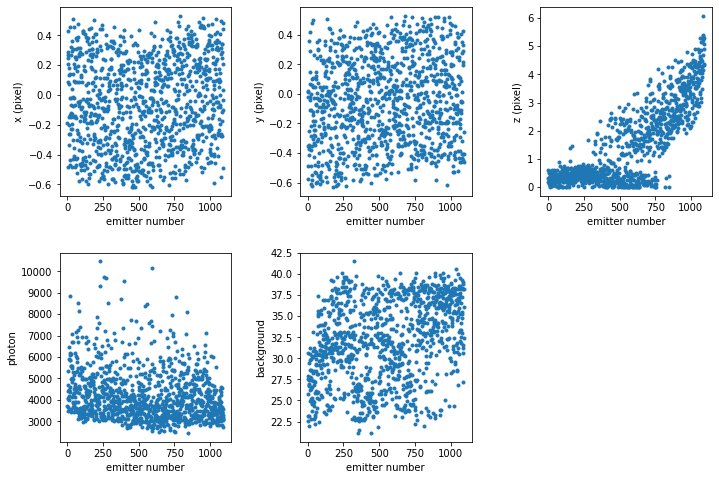

In [24]:
showlearnedparam_insitu(f,p)

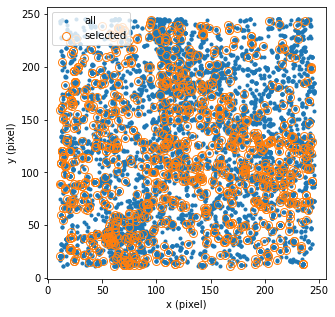

In [25]:
showcoord(f,p)

**Step 4:** check residue stage tilt

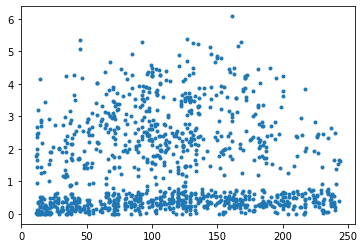

In [26]:
plt.plot(f.res.cor[:,-2],f.res.pos[:,0],'.')

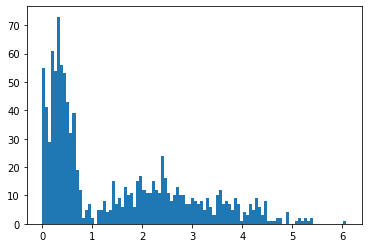

In [27]:

plt.hist(f.res.pos[:,0],bins=100)
plt.show()

adjust lower and upper limit in `mask` to select emitters at the coverslip

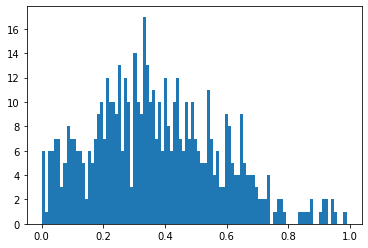

In [28]:
mask = (f.res.pos[:,0]<1) & (f.res.pos[:,0]>0)
plt.hist(f.res.pos[mask,0],bins=100)
plt.show()

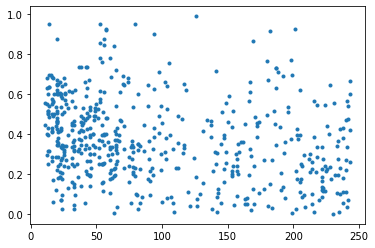

In [29]:
plt.plot(f.res.cor[mask,-1],f.res.pos[mask,0],'.')

estimate residue stage tilt from the selected emitters

In [30]:
X = np.vstack([f.res.cor[mask,-2],f.res.cor[mask,-1],np.ones(np.sum(mask))])
Y = f.res.pos[mask,0]*p.pixel_size.z*1e3
beta=np.matmul(np.matmul(np.linalg.inv(np.matmul(X,X.transpose())),X),Y.transpose())

In [31]:
residue_total_tilt = beta[0:2]*f.rois.image_size[-1] # residual stage tilt across FOV, unit: nm
print('residual total tilt: ',residue_total_tilt)

residual total tilt:  [ 7.01527845 -8.60147896]


**Step 5:** if residue stage tilt is greater than 10 nm, copy the `stagetilt` value to `L.param.option.insitu.stage_tilt` at *Step 3*, and repeat *Steps 3-4*.

In [48]:
stagetilt = p.option.insitu.stage_tilt-beta[0:2] # corrected stage tilt, unit: nm/pixel
print('updated stage tilt: ',list(stagetilt))

updated stage tilt:  [1.0294486385654908, -0.8108117028201274]


**Step 6:** Generate FD psf model for deepfit training

In [37]:
total_tilt = f.res.stagetilt*f.rois.image_size[-1] #total stage tilt across the FOV, unit: um
print('total stage tilt: ',total_tilt.flatten())

total stage tilt:  [ 0.27055416 -0.21616928]


In [38]:
Ndiv = 10 # number of divisions in x and y dimensions across the FOV
xrange = np.linspace(0,f.rois.image_size[-1],Ndiv+1,dtype=np.float32)
yrange = np.linspace(0,f.rois.image_size[-2],Ndiv+1,dtype=np.float32)
[xx,yy] = np.meshgrid(xrange,yrange)
cor = np.vstack((yy.flatten(),xx.flatten())).transpose()
Nz = f.res.I_model.shape[0]
xsz = f.res.I_model.shape[-1]
I_model = []
for i,cori in enumerate(cor):
    stpos = f.res.stagepos + cori[-1]*f.res.stagetilt[-1] + cori[-2]*f.res.stagetilt[-2]
    f,psfobj = L.genpsf(f,Nz=Nz,xsz=xsz,stagepos=stpos)
    I_model.append(f.res.I_model)

I_model = np.stack(I_model)
I_model = np.reshape(I_model,(Ndiv+1,Ndiv+1,Nz,xsz,xsz))

display the FD psf model

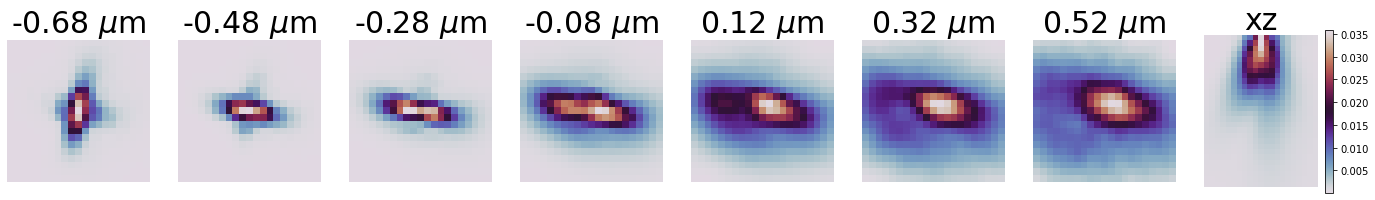

In [41]:
f.res.I_model = I_model[0,0] # first two indices are the global locations of the PSF, unit: division index
showpsf(f,p)

save the FD psf model

In [42]:
f.res.I_model = I_model
filename = resfile[:-3]+'_5D_tilt.h5'
L.writeh5file(filename,f.res,f.locres,f.rois)

**Step 7:** Open `load.jl` in `MicroscopePSF` package (branch: test_IMMpsf), use lines 49-54 to convert above .h5 to .jld2 file.     
**Step 8:** Open `test_train.jl` in `SMLMDeepFit.jl`, use the above generated .jld2 file to for training.   
- set `minz` and `maxz` based on the z range in the spline PSF model.
- set `bgmaxz` equal to `abs(minz)`.
- set `photons` and `minphotons` based on the SMAP localization results.
- set `bg` to be around 1.4 times the median background in the SMAP localization results.   

**Step 9:** Open `inference_visualize_celldata_SEQ_FD.ipynb` in `SMLMDeepFit.jl`, use the trained model for localizations.   
**Step 10:** Use Matlab script `smld2smap.m` to convert .h5 from deepfit to .mat file for visualization in SMAP. 
